In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from westgate.flaml_model import *
import pandas as pd
from westgate.combochart import combo_chart

In [12]:
print(refusal_model.feature_file)
print(default_model.feature_file)

./features_refusal_0.2.csv
../default_model/features_default_1.0.csv


In [5]:
accepted_df = pd.read_csv('../data/AttributesLoans2022.csv', encoding='latin')
refused_raw_df = pd.read_csv('../data/refusal2022.csv', encoding='latin')

C:\Users\karim\AppData\Local\Temp\ipykernel_7824\3967161521.py:1: DtypeWarning: Columns (741) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv('../data/AttributesLoans2022.csv', encoding='latin')


In [6]:
refused_raw_df['recurring_deposits_90_days'] = (
    refused_raw_df['recurring_deposits_current_month'] + 
    refused_raw_df['recurring_deposits_previous_month'] +
    refused_raw_df['recurring_deposits_2_months_ago']
)

refused_raw_df['sum_micro_loans_60_days'] = (
    refused_raw_df['sum_micro_loan_payments_current_month'] + 
    refused_raw_df['sum_micro_loan_payments_previous_month'] 
)

refused_raw_df['recurring_deposits_90_days'] = (
    refused_raw_df['recurring_deposits_current_month'] + 
    refused_raw_df['recurring_deposits_previous_month'] +
    refused_raw_df['recurring_deposits_2_months_ago']
)

refused_raw_df['sum_micro_loans_60_days'] = (
    refused_raw_df['sum_micro_loan_payments_current_month'] + 
    refused_raw_df['sum_micro_loan_payments_previous_month'] 
)

In [7]:
print('# loans before auto-refusal: ' + str(len(refused_raw_df)))

refused_df = refused_raw_df[refused_raw_df['account_age_days'] >= 85]

refused_df = refused_df[refused_df['count_nsf_90_days'] <= 8]

refused_df = refused_df[refused_df['count_nsf_30_days'] <= 6]

refused_df = refused_df[refused_df['count_stop_payment_90_days'] <= 4]

#refused_df = refused_df[refused_df['recurring_deposits_90_days']/3.0 >= 1800] <-- filers way too much

#refused_df = refused_df[refused_df['sum_micro_loans_60_days'] <= 1000]

print('# loans after auto-refusal: ' + str(len(refused_df)))

# loans before auto-refusal: 37398
# loans after auto-refusal: 28579


In [8]:
len(accepted_df)

10098

In [38]:
default_model = UWModel(experiment_id='default_1.0', basefolder='../default_model/')
refusal_model = LendingModel(experiment_id='refusal_0.2')

In [13]:
accepted_filtered_df = default_model.filter_df(accepted_df)

In [14]:
len(accepted_filtered_df)

9507

In [79]:
accepted_filtered_df['refusal'] = 0
refused_df['refusal'] = 1

df = pd.concat([accepted_filtered_df, refused_df])

In [80]:
len(df)

38086

In [82]:
df['refusal'].value_counts(normalize=True)

refusal
1    0.750381
0    0.249619
Name: proportion, dtype: float64

In [34]:
'dob' in df.columns

True

In [84]:
X_train, X_test, y_train, y_test, extra = refusal_model.split_data(df, split_criteria=0.15)

In [85]:
len(X_train)

32373

In [52]:
'dob' in X_train.columns

True

In [86]:
X_train, y_train, X_test, y_test = refusal_model.feature_engineer(X_train, y_train, X_test, y_test)

In [87]:
len(X_train), len(y_train)

(32370, 32370)

In [88]:
X_train.columns

Index(['account_age_days', 'average_monthly_recurring_transfers_in_complex',
       'average_monthly_recurring_transfers_out_complex', 'count_active_days',
       'count_nsf_30_days', 'count_nsf_90_days', 'count_stop_payment_90_days',
       'recurring_deposits_2_months_ago', 'recurring_deposits_current_month',
       'recurring_deposits_previous_month',
       'sum_disability_income_2_months_ago',
       'sum_disability_income_current_month',
       'sum_disability_income_previous_month',
       'sum_employer_income_2_months_ago', 'sum_employer_income_current_month',
       'sum_employer_income_previous_month',
       'sum_employment_insurance_income_2_months_ago',
       'sum_employment_insurance_income_current_month',
       'sum_employment_insurance_income_previous_month',
       'sum_government_income_2_months_ago',
       'sum_government_income_current_month',
       'sum_government_income_previous_month', 'sum_loan_deposits_30_days',
       'sum_loan_deposits_60_days', 'sum_loan

In [89]:
X_train.isna().sum().sum()

0

In [90]:
r = X_train, y_train, X_test, y_test, extra

In [91]:
len(X_test), len(y_test)

(5712, 5712)

In [92]:
y_test.value_counts(normalize=True)

refusal
1    0.752276
0    0.247724
Name: proportion, dtype: float64

X_train shape: (32370, 36)
X_test shape: (5712, 36)



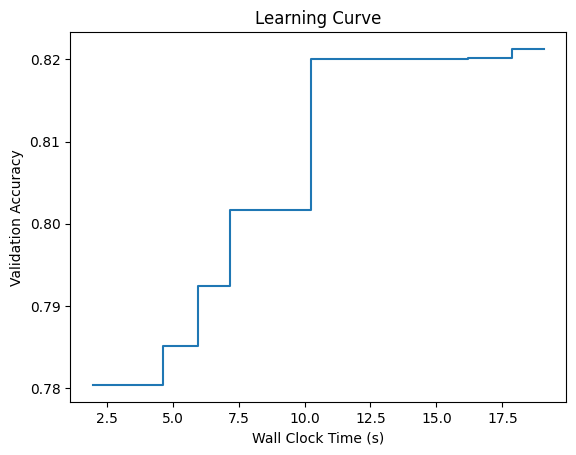

Actual [TEST]:
4297 (75.2%)
Predicted [TEST]:
5671 (99.3%)

y_pred_proba distribution:
(0.000121, 0.1]      97
(0.1, 0.199]         12
(0.199, 0.298]        8
(0.298, 0.398]      172
(0.398, 0.497]      491
(0.497, 0.596]      644
(0.596, 0.695]      631
(0.695, 0.794]      798
(0.794, 0.893]      762
(0.893, 0.992]     2097
Name: count, dtype: int64

Best validation loss: -0.1787150436669079


              precision    recall  f1-score   support

           0       1.00      0.03      0.06      1415
           1       0.76      1.00      0.86      4297

    accuracy                           0.76      5712
   macro avg       0.88      0.51      0.46      5712
weighted avg       0.82      0.76      0.66      5712

Normalized confusion matrix:
[[0.02897527 0.97102473]
 [0.         1.        ]]




In [93]:
y_pred_proba, y_pred, extra = refusal_model.fit(*r, time_budget=20, percentile=0.75)

In [94]:
perf_df = pd.DataFrame({'y_pred': y_pred_proba, 'y_test': y_test})

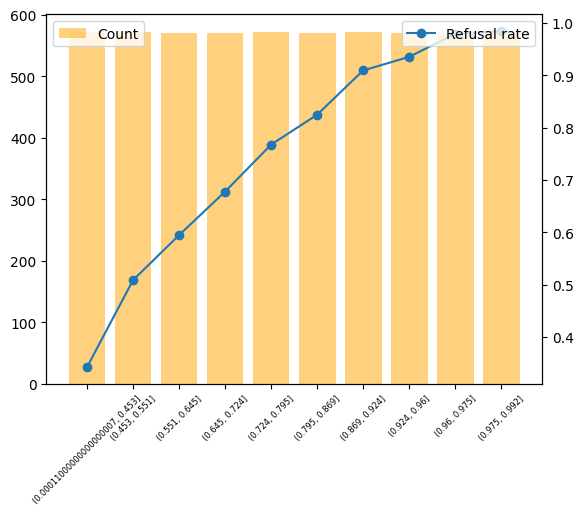

In [98]:
fig = combo_chart(perf_df, xvar='y_pred', q=10, yvar='y_test', ylabel='Refusal rate')

In [100]:
refusal_model.feat_imp()

,variable,imp
16,sum_employer_income_previous_month,0.253021
14,sum_employer_income_2_months_ago,0.160892
29,sum_micro_loan_payments_2_months_ago,0.097068
5,count_nsf_30_days,0.070222
6,count_nsf_90_days,0.056725
28,sum_loan_payments_previous_month,0.038829
1,account_age_days,0.035612
31,sum_micro_loan_payments_previous_month,0.031135
30,sum_micro_loan_payments_current_month,0.029105
35,age,0.022678
